# Apuntes de Copernicus API - Bandas de Sentinel

El satélite Copernicus tiene una API para acceder a sus datasets, en concreto de Sentinel

# Introducción - Librerías, Autenticación y Área de estudio

Librerías básicas: 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Si no tienes utils.py ver Intro_True_Color.ipynb
from utils import plot_image

### Autenticación: 

Aquí voy a usar mis claves.

    Nota: Para obtener las claves hay que registrarse en Copernicus e ir al perfil (donde el dashboard) y ahí ir a configuración. Te podrás abrir una ID para las claves API

In [4]:
config = SHConfig(
  instance_id='',
  sh_client_id='#####################################',
  sh_client_secret='#################################',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

## Monte de El Pardo

In [5]:
pardo_wgs84 = (-3.909490,40.459216,-3.666417,40.627233)

resolution = 10 # metros
pardo_bbox = BBox(bbox=pardo_wgs84, crs=CRS.WGS84) # Importante el crs si se usa otro
pardo_size = bbox_to_dimensions(pardo_bbox, resolution=resolution)

print(f"Tamaño de la imagen en {resolution} m resolución: {pardo_size} pixeles")

Tamaño de la imagen en 10 m resolución: (2075, 1847) pixeles


# Todas las bandas de Sentinel

Vamos a hacer un evalscript que tenga todas las bandas de Sentinel para poder ver de todas las formas posibles el área de estudio. 

Ahora vamos a definir un evalscript que devolverá todas las bandas espectrales de Sentinel-2 con valores en bruto.

En este ejemplo, estamos descargando una cantidad bastante grande de datos, por lo que la optimización de la solicitud está regular. Descargar números digitales en bruto en el formato `INT16` en lugar de reflectancias en el formato `FLOAT32` significa que se descargan muchos menos datos, lo que resulta en una descarga más rápida y un menor uso de unidades de procesamiento de SH.

Para lograr esto, debemos establecer las unidades de entrada en el evalscript a `DN` (números digitales) y el argumento `sampleType` de salida a `INT16`. Además, no podemos empaquetar las 13 bandas de Sentinel-2 en una imagen `PNG`, por lo que debemos establecer el tipo de imagen de salida en el formato `TIFF` a través de `MimeType.TIFF` en la solicitud.

Los números digitales están en el rango de 0-10000, por lo que tenemos que escalar los datos descargados de manera apropiada.
Esto asegura que los datos descargados sean eficientes y manejables, optimizando el uso de recursos y tiempo en el proceso de descarga y análisis de las imágenes satelitales.  ax.set_yticks([])

In [11]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01", // Ultra Blue (Coastal and Aerosol) - 60 m - 443 nm
                        "B02", // Blue - 10 m - 490 nm
                        "B03", // Green - 10 m - 560 nm
                        "B04", // Red - 10 m - 665 nm
                        "B05", // Visible and Near Infrared (VNIR) - 20 m - 705 nm
                        "B06", // Visible and Near Infrared (VNIR) - 20 m - 740 nm
                        "B07", // Visible and Near Infrared (VNIR) - 20 m - 783 nm
                        "B08", // Visible and Near Infrared (VNIR) - 10 m - 842 nm
                        "B8A", // Visible and Near Infrared (VNIR) - 20 m - 865 nm
                        "B09", // Short Wave Infrared (SWIR) - 60 m - 940 nm
                        "B10", // Short Wave Infrared (SWIR) - 60 m - 1375 nm
                        "B11", // Short Wave Infrared (SWIR) - 20 m - 1610 nm
                        "B12"  // Short Wave Infrared (SWIR) - 20 m - 2190 nm
                ],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ), # -------------------------------------------------------- LO MISMO VALE? --------------------------------
            time_interval=("2022-03-01", "2022-03-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
)

El `get.data()` con todas las bandas tarda más, un poco de paciencia

In [12]:
pardo_completo = request_all_bands.get_data()

In [13]:
image = pardo_completo[0]
print(f"Image type: {image.dtype}")
print(f"Image type: {image.dtype}")
print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")

Image type: float32
Image type: float32
Image shape: (1847, 2075, 13)
Image min value: 0.0
Image max value: 26184.0


## Prueba con SWIR: Banda 12

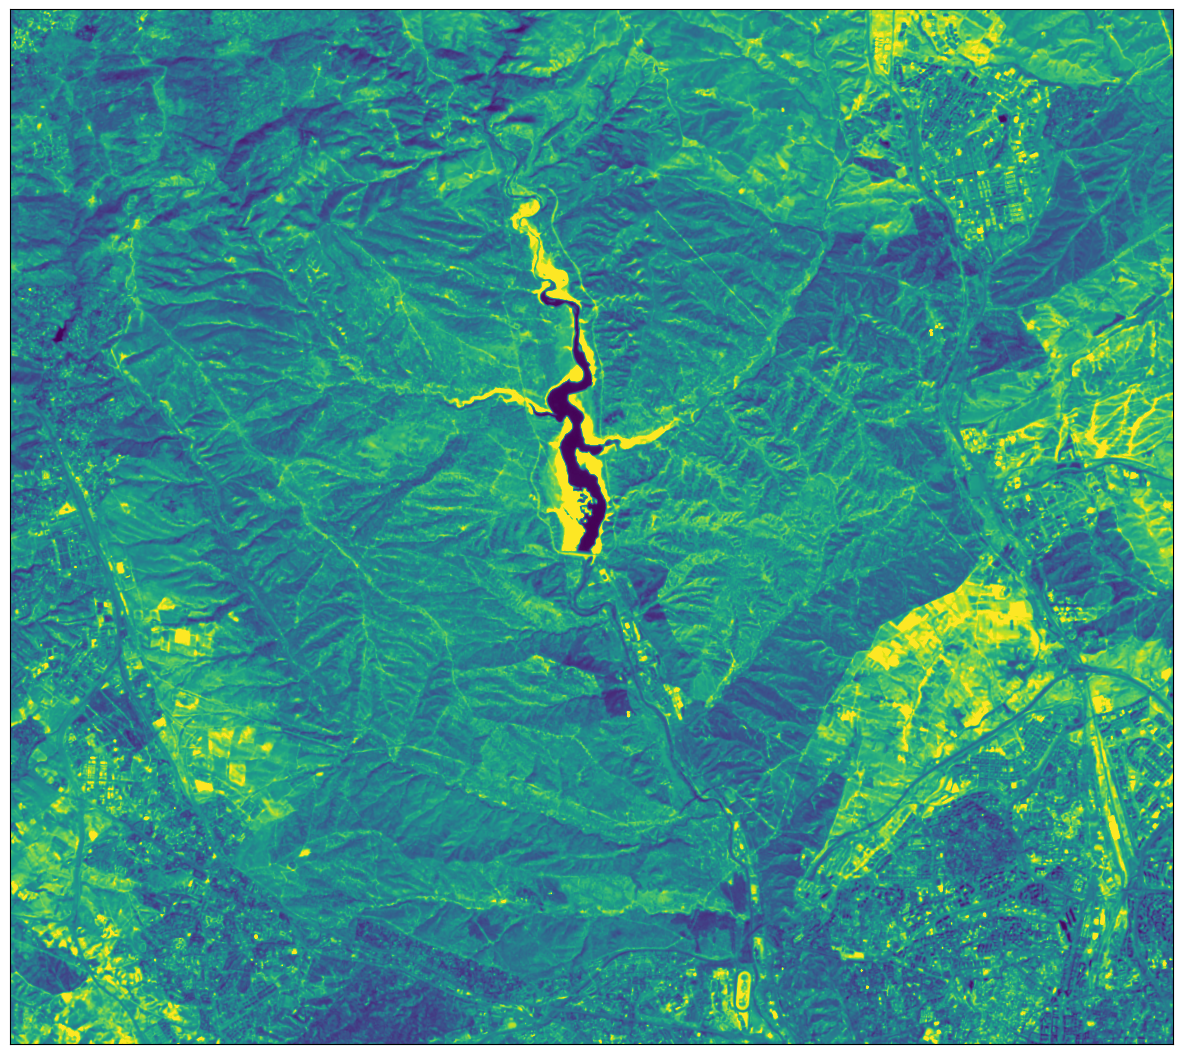

In [14]:
plot_image(pardo_completo[0][:, :, 12], factor=3.5 / 1e4, vmax=1)

El SWIR es útil para ver las zonas de `uso agrícola`, que como se ven en la imagen quedan resaltadas en amarillo. 

He leído que es útil para ver la humedad de las plantas...

### Prueba de máscara de zonas agrícolas

Text(0.5, 1.0, 'Máscara de Áreas potenicales de cultivo')

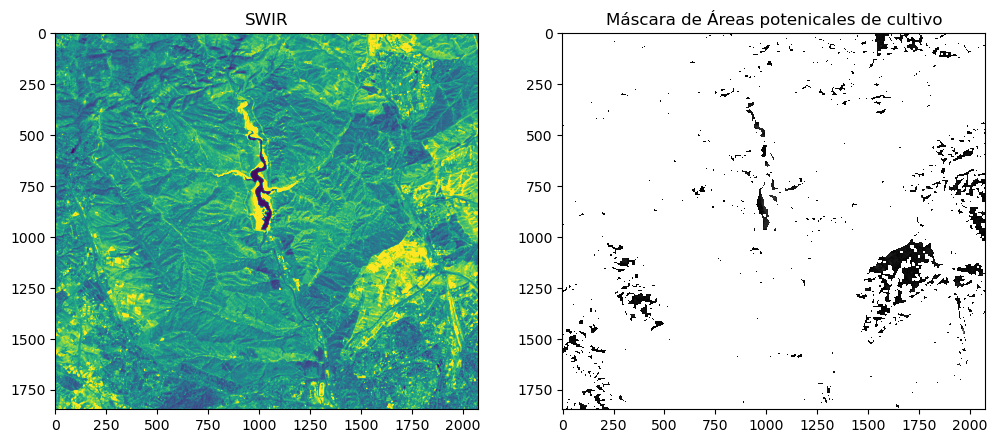

In [180]:
image = pardo_completo[0]  # Selecciona la imagen deseada

# Extraer la banda SWIR
SWIR = image[:, :, 12]  

# Definir un umbral para identificar zonas agrícolas en la banda SWIR
# Este valor es un ejemplo, y puede necesitar ajuste según tu dataset específico
umbral_swir = 1700

# Crear una máscara para zonas agrícolas
# Suponemos que los valores más bajos en SWIR corresponden a vegetación, pero ajusta según sea necesario
mask_agricola = SWIR > umbral_swir

# Crear una imagen enmascarada, estableciendo los valores fuera del rango a NaN para no visualizarlos
swir_masked = np.where(mask_agricola, SWIR, np.nan)

# Mostrar las máscaras en subplots alineados en la misma fila
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(SWIR, cmap="viridis", vmin=0, vmax=2600)
axes[0].set_title('SWIR')

axes[1].imshow(swir_masked, cmap="grey")
axes[1].set_title('Máscara de Áreas potenicales de cultivo')

No me ha quedado muy allá

## Prueba con Falso Color: Bandas 2, 3, 7

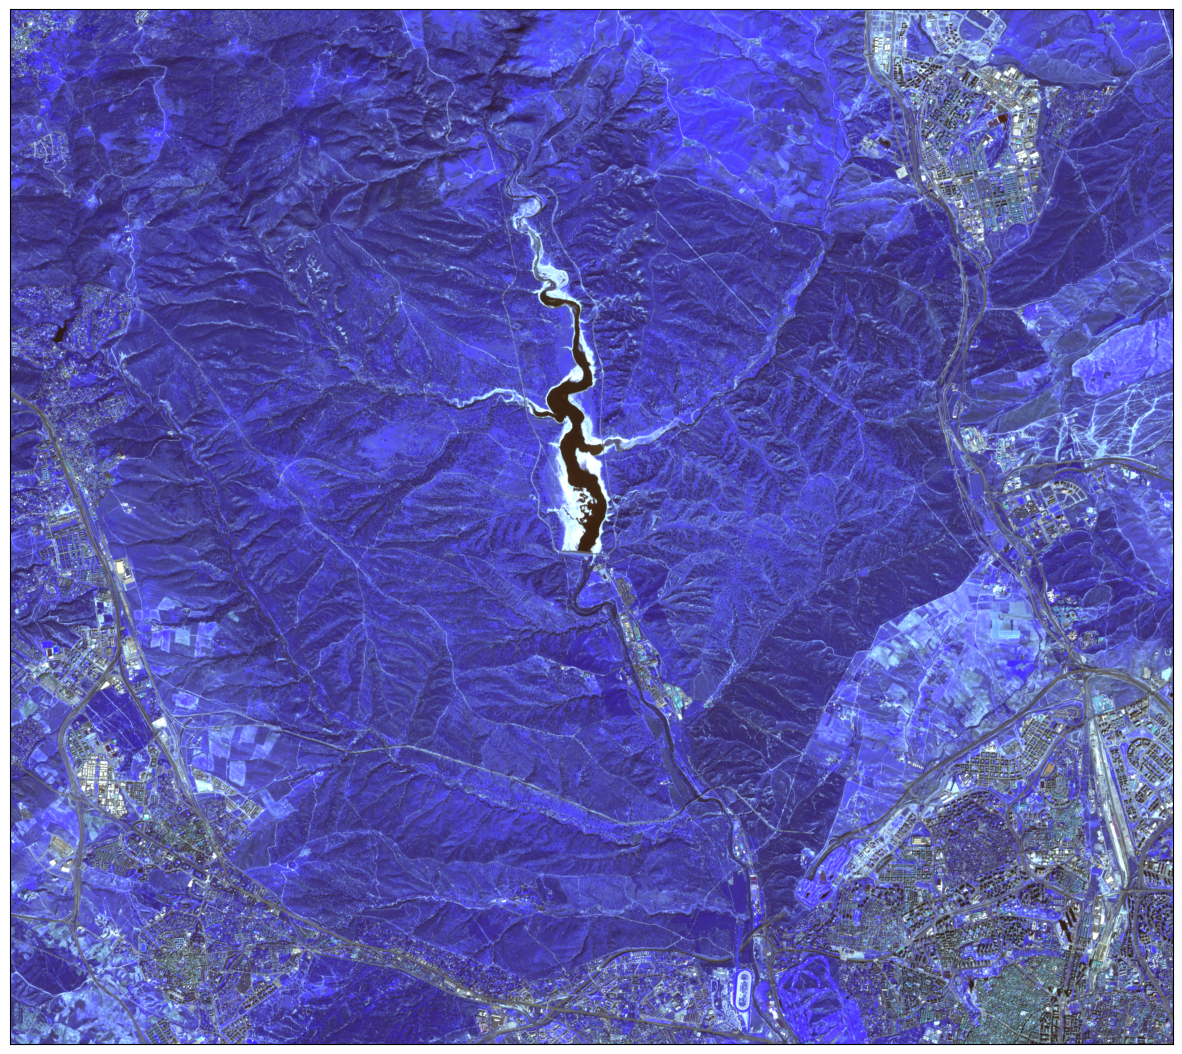

In [15]:
plot_image(pardo_completo[0][:, :, [2, 3, 7]], factor = 3.5/1e4, clip_range = (0, 1))

Falso color es útil para determinar las zonas urbanas, o si lo queremos ver más interesante, las zonas que `no son urbanas`. --> Monte es el territorio no urbano `o agrícola`

### Prueba de máscara de lo que no es monte

In [16]:
# Sacamos la imagen de falso color a una variable
fc = pardo_completo[0][:, :, [2, 3, 7]]

fc.dtype

dtype('float32')

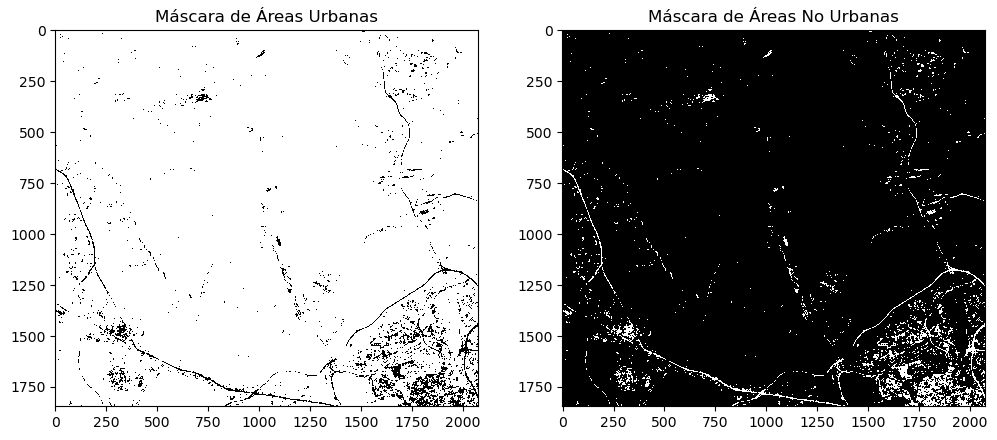

In [19]:
# Separar las bandas
blue_band = fc[:, :, 0]
green_band = fc[:, :, 1]
nir_band = fc[:, :, 2]

# Definir criterios para identificar áreas urbanas basados en los valores de las bandas
# Ajusta estos umbrales según las características específicas de tu imagen
urban_threshold_blue = 500  # Este umbral debe ajustarse según sea necesario
urban_threshold_green = 600  # Este umbral debe ajustarse según sea necesario
urban_threshold_nir = 1500  # Este umbral debe ajustarse según sea necesario

# Crear la máscara de áreas urbanas
urban_mask = (nir_band < urban_threshold_nir) & (blue_band > urban_threshold_blue) & (green_band > urban_threshold_green)

# Crear la máscara inversa (áreas no urbanas)
non_urban_mask = ~urban_mask

# Crear un colormap personalizado
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['white', 'black'])  # Zonas urbanas en negro, no urbanas en blanco

# Mostrar las máscaras en subplots alineados en la misma fila
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(urban_mask, cmap=cmap, vmin=0, vmax=1)
axes[0].set_title('Máscara de Áreas Urbanas')

axes[1].imshow(non_urban_mask, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title('Máscara de Áreas No Urbanas')

plt.show()

## Prueba con NDVI: Bandas (NIR - RED) / (NIR + RED)

El índice diferencial de la vegetación nos aporta mucha información sobre la cobertura vegetal de una zona.

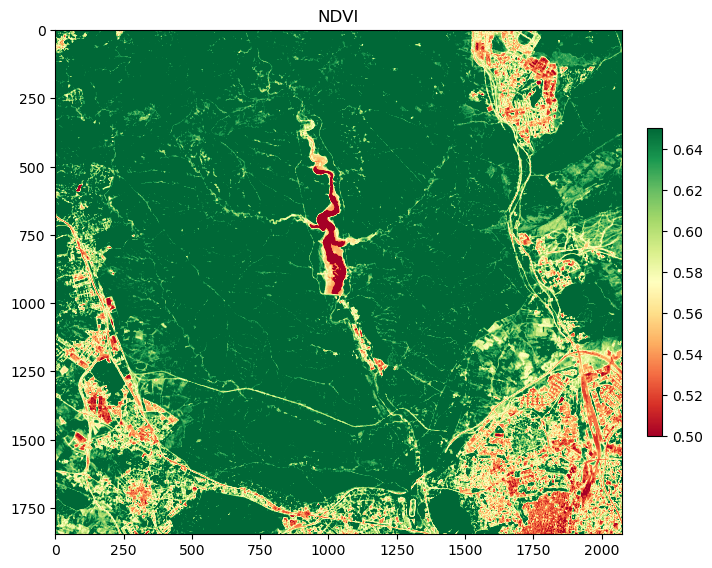

In [111]:
image = pardo_completo[0]  # Selecciona la imagen deseada

# Extraer las bandas
RED = image[:, :, 4]  
NIR = image[:, :, 8]  

# Calcular el NDVI
ndvi = (NIR - RED) / (NIR + RED)

# Normalizar el NDVI para visualización (opcional)
ndvi_normalized = (ndvi + 1) / 2  # Escalar a rango [0, 1]

# Crear la figura y el eje con un tamaño específico
fig, ax = plt.subplots(figsize=(8, 8))

# Mostrar la imagen NDVI
cax = ax.imshow(ndvi_normalized, cmap='RdYlGn', vmin = 0.5, vmax = 0.65)

# Añadir la barra de color con un tamaño ajustado
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, shrink=0.5)

# Título
ax.set_title('NDVI')

# Mostrar la imagen
plt.show()

### Prueba de máscaras de NDVI

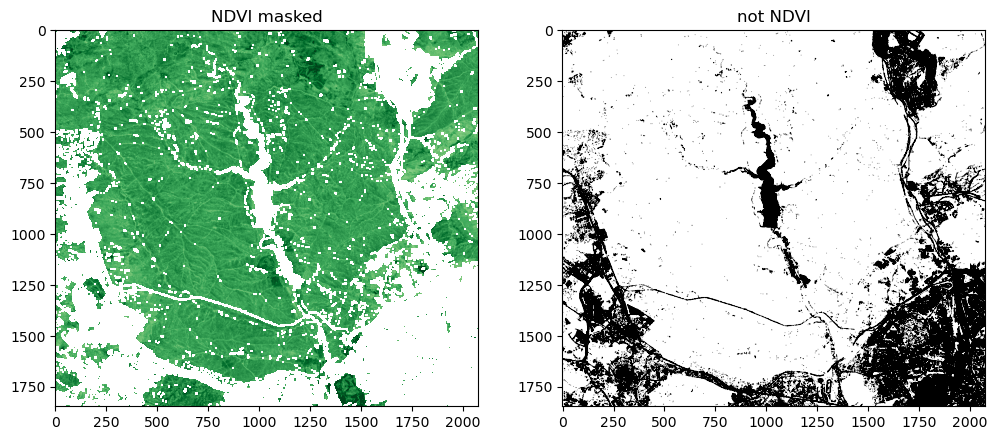

In [110]:
# Crear una máscara para NDVI 
mask = ndvi >= 0.2 # Aquí ha sido un poco prueba y error

imask = ~mask

# Aplicar la máscara, estableciendo los valores fuera del rango a NaN para no visualizarlos
ndvi_masked = np.where(mask, ndvi, np.nan)
ndvi_imasked = np.where(imask, ndvi, np.nan)

# Crear la figura y el eje con un tamaño específico
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar la imagen NDVI enmascarada, utilizando vmin y vmax para mejorar la visualización
axes[0].imshow(ndvi_masked, cmap='Greens', vmin = 0, vmax = 0.5)
axes[0].set_title('NDVI masked')

axes[1].imshow(mask, cmap='grey', vmin = 0.5, vmax = 1)
axes[1].set_title('not NDVI')


# Mostrar la imagen
plt.show()

## Prueba con NDWI: Bandas (Green - NIR) / (Green + NIR)

Este es el índice diferencial del agua, útil para teselar cuerpos de agua

Desde SentinelHub, han hecho un evalscript para el NDWI: [https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/]

Ese evalscript no lo uso aquí porque no se hacer el request luego.

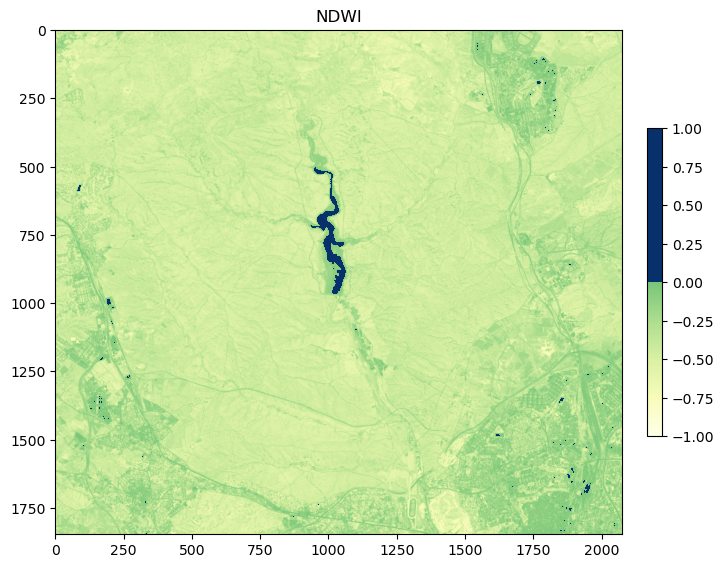

In [225]:
image = pardo_completo[0] 

# Extraer las bandas
Green = image[:, :, 3]  
NIR = image[:, :, 8]  

# Calcular el NDWI
ndwi = (Green - NIR) / (Green + NIR)

# Crear un colormap personalizado
greens = plt.cm.YlGn(np.linspace(0, 0.5, 128)) # ---------------------------------------------------------------------------------------------------------------------
blues = plt.cm.Blues(np.linspace(1, 1, 128)) # ---------------------------------- ESTO ES PARA EL PLOT -----------------------------------------------------------------
newcolors = np.vstack((greens, blues)) # -------------------------------------------------------------------------------------------------------------------------------
newcmp = LinearSegmentedColormap.from_list('GreenBlue', newcolors) # ---------------------------------------------------------------------------------------------------

# Crear la figura y el eje con un tamaño específico
fig, ax = plt.subplots(figsize=(8, 8))

# Mostrar la imagen NDWI con el colormap personalizado
cax = ax.imshow(ndwi, cmap=newcmp, vmin=-1, vmax=1)

# Añadir la barra de color con un tamaño ajustado
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, shrink=0.5)

# Título
ax.set_title('NDWI')

# Mostrar la imagen
plt.show()
